In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset
import itertools

from torch import nn

dataset = load_dataset("McGill-NLP/feedbackQA")

Found cached dataset feedback_qa (/home/raja/.cache/huggingface/datasets/McGill-NLP___feedback_qa/plain_text/1.0.0/20c8f938f417c88303bb7041cea9554c1d14667686d7d7c5dda83dd4f39e5dc4)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
rating_class = {'Excellent':3 , 'Acceptable':2 , 'Could be Improved':1, 'Bad': 0}

def process_df(df):
    df['list_feedback'] = df['feedback'].apply(lambda x: [ r + "___" + e for r,e in zip(x['rating'],x['explanation']) ])
    df['sampled_feedback'] = df['list_feedback'].apply(lambda x: np.random.choice(x).split("___") )
    df['rating_class'] = df['sampled_feedback'].apply(lambda x: rating_class[x[0]])
    df['rating'] = df['sampled_feedback'].apply(lambda x: x[0])
    df['explanation'] = df['sampled_feedback'].apply(lambda x: x[1])
    return df

In [3]:
train_df = process_df(pd.DataFrame(dataset['train']))
val_df = process_df(pd.DataFrame(dataset['validation']))
test_df = process_df(pd.DataFrame(dataset['test']))

In [4]:
train_df['feedback'].loc[0]

{'rating': ['Excellent', 'Could be Improved'],
 'explanation': ['Has a link to detailed information about government programs for job seekers.',
  'This answer provides a link for job searches, which is good, but also provides links to unrelated sites.']}

In [5]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader

# Load model from HuggingFace Hub
bert_chkpt = "sentence-transformers/all-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(bert_chkpt)
model = AutoModel.from_pretrained(bert_chkpt)

In [6]:
tokenizer.all_special_tokens

['<s>', '</s>', '[UNK]', '<pad>', '<mask>']

In [7]:
train_df.head()

,question,answer,feedback,list_feedback,sampled_feedback,rating_class,rating,explanation
0,How do I get help finding a job?,Coronavirus (COVID-19) information for job see...,"{'rating': ['Excellent', 'Could be Improved'],...",[Excellent___Has a link to detailed informatio...,"[Could be Improved, This answer provides a lin...",1,Could be Improved,"This answer provides a link for job searches, ..."
1,How do I get help finding a job?,Coronavirus (COVID-19) information for job see...,"{'rating': ['Excellent', 'Excellent'], 'explan...",[Excellent___A link to a job search website is...,"[Excellent, A link to a job search website is ...",3,Excellent,"A link to a job search website is included, as..."
2,How do I get help finding a job?,Coronavirus (COVID-19) information and support...,"{'rating': ['Bad', 'Acceptable'], 'explanation...",[Bad___Talks about tax credits for businesses ...,"[Bad, Talks about tax credits for businesses t...",0,Bad,Talks about tax credits for businesses that hi...
3,If I am in Australia on a worker holiday marke...,Frequently Asked Questions\nWorking holiday ma...,"{'rating': ['Could be Improved', 'Acceptable']...",[Could be Improved___Answer is about Working H...,"[Could be Improved, Answer is about Working Ho...",1,Could be Improved,"Answer is about Working Holiday Makers, but do..."
4,If I am in Australia on a worker holiday marke...,Frequently Asked Questions\nCOVID-19 Pandemic ...,"{'rating': ['Bad', 'Could be Improved'], 'expl...",[Bad___Discusses pandemic visas. Doesn't menti...,"[Could be Improved, This answer is very vague ...",1,Could be Improved,This answer is very vague and does not answer ...


In [8]:
train_df['answer'].loc[0]

'Coronavirus (COVID-19) information for job seekers\nExisiting job seekers\nIf you are a current job seeker or participant, this fact sheet provides\nimportant information about mutual obligation requirements, appointments with\nyour provider, and what to do if you are self-isolating:\n\nInformation for job seekers and participants\n\nIf you are participating in the ParentsNext program, this fact sheet provides\nimportant information about your activities and appointments.\n\n\nInformation for ParentsNext participants\n\n\nParentsNext participants Frequently Asked Questions\n\n\nIf you are a New Business Assistance with NEIS participant, these Frequently\nAsked Questions (FAQ) provides information about accessing the Coronavirus\nSupplement and what support is available during this time:\n\nNew Business Assistance with NEIS participants - Frequently Asked Questions\n\nIf you are a New Business Assistance with NEIS provider, these Frequently\nAsked Questions (FAQ) provides information a

In [9]:
tokenizer('Hello, how are you doing?'+ f" {tokenizer.eos_token} " + "Hemlooooo",add_special_tokens=True,return_tensors='pt', return_length=1)

{'input_ids': tensor([[    0,  7596,  1014,  2133,  2028,  2021,  2729,  1033,     2, 19614,
          4139,  9545,  9545,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'length': tensor([14])}

In [10]:
from nltk import tokenize as nltk_tokenizer
len(nltk_tokenizer.sent_tokenize(train_df['answer'].loc[0]))

3

In [11]:
import tqdm

class feedback_QA_dataset(Dataset):
    
    def __init__(self,df,max_length=512):
        self.df = df
        self.max_len = max_length
        self.data = []
        skipped = 0
        
        for i in tqdm.tqdm(range(len(self.df)),desc='vectorizing..'):
            
            for j in range(len(self.df.iloc[i]['feedback']['rating'])):
                d = {}
            
                tok_question = tokenizer('Question: ' + self.df.iloc[i]['question'] + ' Answer: ', add_special_tokens=False)
                tok_answer = tokenizer(self.df.iloc[i]['answer'], add_special_tokens=False)
                tok_feedback = tokenizer(self.df['feedback'].iloc[i]['explanation'][j], add_special_tokens=False)

                if len(tok_question['input_ids']+tok_answer['input_ids']+tok_feedback['input_ids'])+4 > self.max_len:
                    skipped +=1
                    continue

                context = [tokenizer.bos_token_id] + tok_question['input_ids'] + tok_answer['input_ids']
                context_attn = [1] + tok_question['attention_mask'] + tok_answer['attention_mask']
                context_pool_mask = [0] + [0]*len(tok_question['input_ids']) + tok_answer['attention_mask']


                d['context_w_feedback'] = context + [tokenizer.sep_token_id]*2 + tok_feedback['input_ids'] + [tokenizer.eos_token_id]

                PAD_LEN = self.max_len - len(d['context_w_feedback'])

                d['context_w_feedback'] += [tokenizer.pad_token_id]*PAD_LEN
                d['context_w_feedback_attn'] = context_attn + [1,1] + tok_feedback['attention_mask'] + [1] + [0]*PAD_LEN            

                d['feedback_pool_mask'] = [0]*len(context_pool_mask) + [0,0] + tok_feedback['attention_mask'] + [0] + [0]*PAD_LEN

                d['rating_class'] = rating_class[self.df['feedback'].iloc[i]['rating'][j]]
                
                for k in d.keys():
                    d[k] = torch.tensor(d[k])

                self.data.append(d)
        print(f'skipped: {skipped}')

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        return self.data[idx]

In [12]:
train_dataset = feedback_QA_dataset(train_df)
valid_dataset = feedback_QA_dataset(val_df)
test_dataset = feedback_QA_dataset(test_df)

vectorizing..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5660/5660 [00:21<00:00, 262.33it/s]


skipped: 867


vectorizing..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1410/1410 [00:05<00:00, 255.36it/s]


skipped: 210


vectorizing..: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1995/1995 [00:12<00:00, 161.20it/s]

skipped: 516


In [13]:
train_DL = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_DL = DataLoader(valid_dataset,batch_size=32,shuffle=True)
test_DL = DataLoader(test_dataset,batch_size=1,shuffle=False)

In [14]:
for b in train_DL:
    for k in b.keys():
        print(k,b[k].shape)
    break

context_w_feedback torch.Size([32, 512])
context_w_feedback_attn torch.Size([32, 512])
feedback_pool_mask torch.Size([32, 512])
rating_class torch.Size([32])


In [15]:
from transformers import BartForConditionalGeneration

device = 'cuda:0'

model = AutoModel.from_pretrained(bert_chkpt).to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    se = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return F.normalize(se, p=2, dim=1)

j = 0

with torch.no_grad():
    for b in train_DL:
        out = mean_pooling( model(input_ids=b['context_w_feedback'].to(device), attention_mask=b['context_w_feedback_attn'].to(device)) , b['feedback_pool_mask'].to(device))
        print(out.shape)
        print('----------------------------')
        j+=1
        if j>5:
            break

del model

torch.Size([32, 768])
----------------------------
torch.Size([32, 768])
----------------------------
torch.Size([32, 768])
----------------------------
torch.Size([32, 768])
----------------------------
torch.Size([32, 768])
----------------------------
torch.Size([32, 768])
----------------------------


In [16]:
t = torch.tensor([[[1,2,3,4,5],[6,7,8,9,0]]])
t.repeat(2,1,1)

tensor([[[1, 2, 3, 4, 5],
         [6, 7, 8, 9, 0]],

        [[1, 2, 3, 4, 5],
         [6, 7, 8, 9, 0]]])

In [17]:
class classifier(nn.Module):

    def __init__(self, model_chkpt, device='cuda:0', inp_dim=768, hidden_dims=None, num_classes=4, use_norm=False):
        super().__init__()
        
        self.device = device
        self.bert_model = AutoModel.from_pretrained(model_chkpt).to(device)
        
        self.use_norm = use_norm
        self.inp_layer = nn.Linear(inp_dim,hidden_dims[0])

        hidden_layers = []
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i],hidden_dims[i+1]))
            hidden_layers.append(nn.Dropout(p=0.2))
            hidden_layers.append(nn.ReLU())
        self.layers = nn.Sequential(*hidden_layers)

        self.out_layer = nn.Linear(hidden_dims[-1],num_classes)
        
    def mean_pooling(self,model_output,attention_mask):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        se = torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        return se
        
    def forward(self, b):
        y = self.mean_pooling( self.bert_model(input_ids=b['context_w_feedback'].to(self.device), attention_mask=b['context_w_feedback_attn'].to(self.device)),
                               b['feedback_pool_mask'].to(self.device))
        if self.use_norm:
            y = F.normalize(y,p=2,dim=-1)
        y = self.inp_layer(y)
        y = F.relu(y)
        y = self.layers(y)
        y = self.out_layer(y)
        
        return_dict = {}
        
        return_dict['logits'] = y
        return_dict['class_probs'] = F.softmax(y,dim=-1)
        return_dict['CE_loss'] = F.cross_entropy(y,b['rating_class'].to(self.device))
        return return_dict
        
        

In [18]:
def train(classifier,train_dl,valid_dl,epochs,optimizer,PATIENCE=20,save_dir=None):

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    
    classifier.train()
    
    loss_acc = 0
    num_batches = 0
    total_steps = 0
    best_valid_loss = np.inf
    patience = PATIENCE
    
    train_loss_arr,valid_loss_arr = [],[]
    
    optimizer.zero_grad()
    classifier.zero_grad()
    
    for E in range(epochs):
        
        num_samples = 0
        
        for b in train_dl:
            
            y = classifier(b)
                          # decoder_input_ids=b['feedback'].squeeze(1)[:,:-1].to(device),
                          # decoder_attention_mask=b['feedback_attn'].squeeze(1)[:,:-1].to(device))
            loss = y['CE_loss'] #F.cross_entropy(y.logits.permute(0,2,1), b['feedback'].squeeze(1)[:,1:].to(device), ignore_index=tokenizer.pad_token_id)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_acc += loss.item()
        
            num_batches += 1
            total_steps += 1

            train_loss_arr.append(loss_acc/num_batches)

            if total_steps%100==0 and total_steps!=0:
                print("Epoch:",E,"\t","Steps taken:",total_steps,"\tLoss:",loss_acc/num_batches)
            
        #print("Epoch:",E,"\t","Steps taken:",total_steps,"\tLoss:",loss_acc/num_batches)
        
        torch.save({'model_state':classifier.state_dict(),
                    'optimizer':optimizer.state_dict(),
                    'epoch':E},
                    f"{save_dir}/Epoch_{E}_model_chkpt.pth.tar")
        
        valid_loss = validate(classifier,valid_dl)
        valid_loss_arr.append(valid_loss/len(valid_dl))
        
        if valid_loss<best_valid_loss:
            best_valid_loss = valid_loss
            patience = PATIENCE
            
            torch.save({'model_state':classifier.state_dict(),
                        'optimizer':optimizer.state_dict(),
                        'epoch':E},
                        f"{save_dir}/best_model_chkpt.pth.tar")
        else:
            patience -= 1
            print(f"REDUCING PATIENCE...{patience}")

        if patience<=0:
            print("RUNNING OUT OF PATIENCE... TERMINATING")
            break
    
    
    return train_loss_arr,valid_loss_arr
                

In [19]:
def validate(classifier,valid_dl):
    
    classifier.eval()
    valid_loss = 0
    num_batches = 0
    with torch.no_grad():
        for b in valid_dl:
            y = classifier(b)
                          # decoder_input_ids=b['feedback'].squeeze(1)[:,:-1].to(device),
                          # decoder_attention_mask=b['feedback_attn'].squeeze(1)[:,:-1].to(device))
            loss = y['CE_loss'] #F.cross_entropy(y.logits.permute(0,2,1), b['feedback'].squeeze(1)[:,1:].to(device), ignore_index=tokenizer.pad_token_id)
            valid_loss += loss.item()
            num_batches+=1
            
    print("Validation Loss:",valid_loss/num_batches)
    return valid_loss

In [20]:
import os

from transformers import AutoModel

EPOCHS = 50
FREEZE_BERT = False

device = 'cuda:0'

# MPNet = AutoModel.from_pretrained(bert_chkpt).to(device)
classifier_model = classifier(bert_chkpt,device=device,hidden_dims=[768,128], num_classes=4, use_norm=False).to(device)

In [ ]:
if FREEZE_BERT:
    classifier_model.load_state_dict(torch.load('Rating_ctxt_FB_MPNET_chkpts_1/best_model_chkpt.pth.tar')['model_state'])
    classifier_model.bert_model.requires_grad_(False)

optimizer = torch.optim.AdamW(classifier_model.parameters(),lr=1e-4)

save_dir = 'Rating_ctxt_FB_MPNET_chkpts_1'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

train_loss,valid_loss = train(classifier_model,
                              train_DL,
                              valid_DL,
                              EPOCHS,
                              optimizer,
                              PATIENCE=5,
                              save_dir=save_dir)

In [ ]:
import json

with open('train_loss.json','w') as f:
    json.dump(train_loss,f)

with open('valid_loss.json','w') as f:
    json.dump(valid_loss,f)

In [ ]:
train_loss_ds = np.array(train_loss)[np.round(np.linspace(0, len(train_loss) - 1, len(valid_loss))).astype(int)]
loss_df = pd.DataFrame({'train_loss':train_loss_ds , 'valid_loss':valid_loss})

In [ ]:
from plotly import express as px
px.line(loss_df,y=['train_loss','valid_loss'])

In [21]:
test_DL = DataLoader(test_dataset,batch_size=100,shuffle=False)

In [22]:
chkpt = torch.load('Rating_ctxt_FB_MPNET_chkpts_1/best_model_chkpt.pth.tar')

In [23]:
classifier_model.load_state_dict(chkpt['model_state'])

<All keys matched successfully>

In [24]:
i = 0
preds,gt = [],[]
classifier_model.eval()
with torch.no_grad():
    for b in tqdm.tqdm(test_DL,desc='evaluating'):
        out = classifier_model(b)
        pred_labels = out['class_probs'].argmax(dim=-1).cpu().tolist()
        gt_labels = b['rating_class'].tolist()
        preds.extend(pred_labels)
        gt.extend(gt_labels)

evaluating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [00:36<00:00,  1.51it/s]


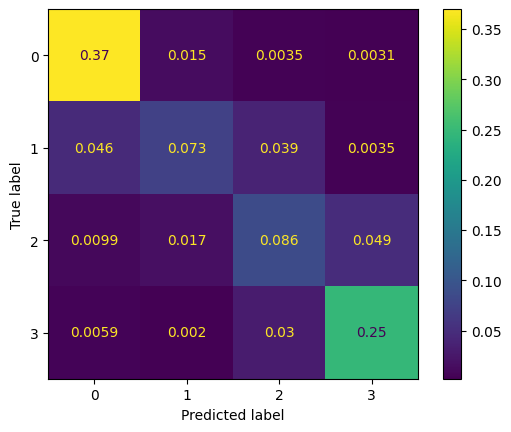

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
cm = confusion_matrix(gt,preds,normalize='all')
ConfusionMatrixDisplay(cm).plot()

In [28]:
len(gt)

5469

In [26]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
print('Precision: ' , precision_score(gt,preds,average='macro'))
print('Recall: ' , recall_score(gt,preds,average='macro'))
print('Accuracy: ' , accuracy_score(gt,preds))

Precision:  0.7251665809916635
Recall:  0.6994580322872425
Accuracy:  0.7767416346681295


In [27]:
print('Precision: ' , precision_score(gt,preds,average='micro'))
print('Recall: ' , recall_score(gt,preds,average='micro'))
print('Accuracy: ' , accuracy_score(gt,preds))

Precision:  0.7767416346681295
Recall:  0.7767416346681295
Accuracy:  0.7767416346681295
